In [1]:
import pandas as pd 
import numpy as np
from team import Team,UpdateGamei
from Betting import *
from dataset import *
from Utils import *

2021/2022 Dataset:

In [2]:
Dataset=FootballDataset('E0_2022.csv')
data=Dataset.data
team_names=Dataset.team_names()
Under,Over=Dataset.get_odds()
Undercote,Overcote=[1/Under[i] for i in range(len(Under))],[1/Over[i] for i in range(len(Under))]
y=Dataset.get_y()
teams=[Team(i,team_names) for i in range(1,21)]

2022/2023 Dataset :

In [3]:
Dataset_2023=FootballDataset('E0_2023.csv')
data_2023=Dataset_2023.data
team_names_2023=Dataset_2023.team_names()
Under_2023,Over_2023=Dataset_2023.get_odds()
Undercote_2023,Overcote_2023=[1/Under_2023[i] for i in range(len(Under_2023))],[1/Over_2023[i] for i in range(len(Under_2023))]
y_2023=Dataset_2023.get_y()
teams_2023=[Team(i,team_names_2023) for i in range(1,21)]

In [27]:
Releguated=Dataset.Releguated(team_names)

Predicting:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

def Predict(lam,phi1,phi2,teams,y,Over,Undercote,Overcote,data,Dataset,team_names,mode,init_option=True):
    
    L=[]
    initialize_burn_in(lam,phi1,phi2,teams,team_names,data,62,mode,init_option)
    X=features_up_tomatchej(lam,phi1,phi2,len(data),Over,teams,team_names,data,Dataset,mode)
    
    
    E=np.arange(62,len(data)+1,10)
    
    logreg = LogisticRegression()
    T=Betting()
    
    # Create an empty array for concatenation
    all_probs = np.empty((0, 2))
    acc=0
    for i in range(len(E)-2):
        
        X_train,y_train=X[ E[0]-62:E[i+1]-62 ], y[ E[0]:E[i+1] ]        #### Features to train on 
        
        X_bet,y_bet=X[ E[i+1]-62 : E[i+2]-62 ], y[ E[i+1] : E[i+2] ]    ### 10 features ahead for bettings        
        
        logreg.fit(X_train,y_train)                                     ### Fitting

        logreg_prob=logreg.predict_proba(X_bet)                         ### Predicting

        prob=np.array(logreg_prob)                                      ### Probabilities
        
        # Concatenate the probabilities
        all_probs = np.concatenate([all_probs, prob])
        
        #Betting
        PROFIT=T.kellybetting_unitlist(prob,y_bet,Overcote[E[i+1]-62 : E[i+2]-62],Undercote[E[i+1]-62 : E[i+2]-62],0.1)
        L=np.concatenate([L,PROFIT])
    
        
        acc+=T.accuracy(y_bet,prob)
        
    
    loss=log_loss(y[E[1]:E[len(E)-1]],all_probs)
    accuracy=acc/len( y[ E[1]:E[len(E)-1 ]] )
    netreturn=T.stack_kelly_unit/T.number_of_bets
    
    return loss,netreturn,accuracy

In [6]:
Predict(2.96644798, 0.34056246, 0.17475957,teams,y,Over,Undercote,Overcote,data,Dataset,team_names,'G',True)


(0.7108144338736487, 1.0133098561330331, 0.52)

Optimization Function :

In [8]:
from scipy.optimize import minimize
def Optimize(lam, phi1, phi2):
    def objective_function(x):
        return Predict(x[0], x[1], x[2], teams,y,Over,Undercote,Overcote,'G')[0]
    
    bounds = [(0.1, 30), (0.1, 0.95), (0.1, 0.95)] # set the bounds for the first three parameters
    
    result = minimize(objective_function, x0=[lam, phi1, phi2], bounds=bounds,method='nelder-mead',options={'disp': True})
    Xr=result.x
    return Xr,Predict(Xr[0], Xr[1], Xr[2],teams,y,Over,Undercote,Overcote,'G')

In [34]:
Optimize(1.5,0.7,0.3)

Optimization terminated successfully.
         Current function value: 0.706169
         Iterations: 46
         Function evaluations: 97


(array([1.83543027, 0.71279278, 0.23668155]),
 (0.7061690853062621, 1.0264529742236286, 0.53))

Optimization by hand

In [20]:
A=np.linspace(0.1,0.9,20)
B=np.linspace(0.1,0.9,20)

Loss=np.zeros((len(A),len(B)))
profit=np.zeros((len(A),len(B)))
avgret=np.zeros((len(A),len(B)))
accuracy=np.zeros((len(A),len(B)))
for i in range(len(A)):
    for j in range(len(B)):
        
        a,b,c=Predict(2,A[i],B[j],teams,y,Over,Undercote,Overcote,'G+S+C')
        Loss[i][j]=a
        profit[i][j]=b
        
        

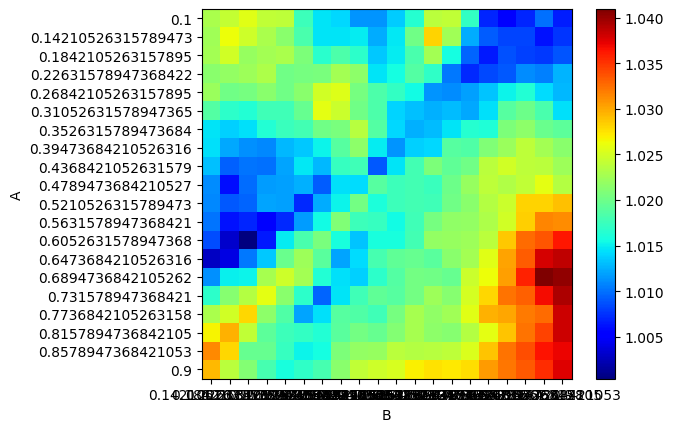

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define A, B, and Result matrices


plt.imshow(profit,cmap='jet')
plt.xticks(np.arange(len(A)), A)
plt.xlabel('B')
plt.yticks(np.arange(len(B)), B)
plt.ylabel('A')
plt.colorbar()
plt.show()

In [32]:
maximum = np.max(profit)
max_index = np.unravel_index(np.argmax(profit, axis=None), profit.shape)
print(maximum,max_index)

1.0409572210571647 (14, 18)


In [35]:
maximum = np.min(Loss)
max_index = np.unravel_index(np.argmin(Loss, axis=None),Loss.shape)
print(maximum,max_index)

0.7040685716581768 (19, 0)


Keeping Ratings 2/3 of the Promoted Teams


In [42]:
teams_2023=[Team(i,team_names_2023) for i in range(1,21)]
for i in range(0,20):
    
    if teams_2023[i].name == teams[i].name:
        a,b,c,d=np.array(teams[i].get())*(2/3)
        teams_2023[i].update(a,b,c,d)



In [31]:
print_team_stats(teams_2023)

The best Home attacking team is: Arsenal (12.893121212228396)
The best Home defensing team is: Liverpool (0)
The best Away attacking team is: Leeds (5.2139999999999995)
The best Away defensing team: Liverpool (0)


The three best overall teams with the highest average attacking attribute are:
Arsenal (14.134717365607846)
Leeds (10.593333333333334)
Aston Villa (9.827473678836114)
Man City (9.111850360099783)
Everton (7.576140106470916)


The three best overall teams with the highest average defending attribute are:
Liverpool (0)
Brighton (0)
Bournemouth (0)
Nott'm Forest (0)
Fulham (0)




Predicting with optimized parametres:

In [43]:
Predict(1,A[19],B[0],teams_2023,y_2023,Over_2023,Undercote_2023,Overcote_2023,data_2023,Dataset_2023,team_names_2023,'G+S+C',False)

(0.7036438152521963, 1.0661267943208446, 0.5576923076923077)

In [ ]:
###Around 7% Profitability over 2023 